### Installation/Initialization

In [14]:
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers import (
    GroundingDinoProcessor,
    GroundingDinoForObjectDetection,
    Sam2Processor,
    Sam2Model,
    Sam2VideoModel,
    Sam2VideoProcessor,
)

# from sam2.sam2_image_predictor import SAM2ImagePredictor
# from sam2.sam2_video_predictor import SAM2VideoPredictor

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Load models

In [7]:
# Load GroudingDino (processor + model)
gd_model_id = "IDEA-Research/grounding-dino-tiny"  # or another HF checkpoint
gd_processor = GroundingDinoProcessor.from_pretrained(gd_model_id)
gd_model = GroundingDinoForObjectDetection.from_pretrained(gd_model_id).to(device)

# Load SAM2 (model + processor)
sam2_model_id = "facebook/sam2.1-hiera-large"  # or another SAM2 variant

You are using a model of type sam2_video to instantiate a model of type sam2. This is not supported for all configurations of models and can yield errors.


### Convert text to region seeds using GroundingDino

In [10]:
def groundingDino(image, prompt):
  # Image preprocessing and text tokenization
  inputs = gd_processor(images=image, text=[prompt], return_tensors="pt").to(device)     # Note: `text` is wrapped as list (batch).
  # Forward pass
  outputs = gd_model(**inputs)
  # Postprocessing GroundingDino detections
  results = gd_processor.post_process_grounded_object_detection(
      outputs,
      threshold=0.3,
      text_threshold=0.25,
      target_sizes=[image.size[::-1]]  # (height, width)
  )
  # results is a list (one per image in batch)
  res = results[0]
  boxes = res["boxes"]       # Tensor of shape [num_boxes, 4]
  scores = res["scores"]     # Tensor of confidences
  labels = res["labels"]     # Text labels for each box
  # Choose one box (for example, the highest score)
  best_idx = scores.argmax().item()
  chosen_box = boxes[best_idx].detach().cpu().tolist()  # [x0, y0, x1, y1]
  return chosen_box

Enter 1 for image or 2 for video: 1


You are using a model of type sam2_video to instantiate a model of type sam2. This is not supported for all configurations of models and can yield errors.


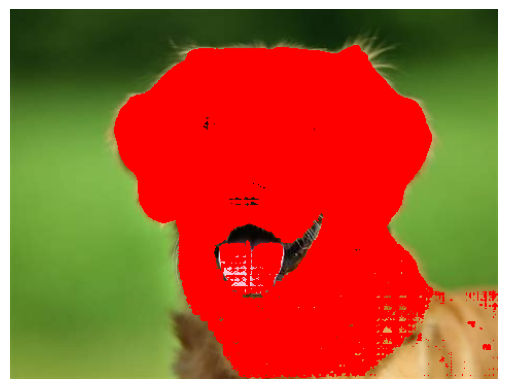

In [15]:
while True:
  choice = input("Enter 1 for image or 2 for video: ")
  if choice.strip() in ["1", "2"]:
    choice = int(choice)
    break

if choice == 1:
  # Load SAM2
  sam2_model = Sam2Model.from_pretrained(sam2_model_id).to(device)
  sam2_processor = Sam2Processor.from_pretrained(sam2_model_id)

  #Load image
  image_in_path = "Dog.jpeg"
  image_out_path = f"{image_in_path.rsplit(".")[0].strip()}_segmented.mp4"
  image = Image.open(image_in_path)
  prompt = "A dog"

  # Use GroundingDINO to find box
  chosen_box = groundingDino(image, prompt)
  # Wrap in list for batch dimension
  input_boxes = [[chosen_box]]  # list length = batch size = 1
  # Feed bounding box into SAM2
  sam2_inputs = sam2_processor(
      images=image,
      input_boxes=input_boxes,
      return_tensors="pt"
  ).to(device)

  with torch.no_grad():
      sam2_outputs = sam2_model(**sam2_inputs)

  # Postprocess SAM2 masks to original size
  masks = sam2_processor.post_process_masks(
      sam2_outputs.pred_masks.cpu(),
      sam2_inputs["original_sizes"].cpu(),
  )
  # `masks` is a list (one per image in batch). Here batch size = 1
  mask_for_image = masks[0]   # shape [num_masks, H, W] (if multimask_output=False, num_masks=1)
  mask = mask_for_image[0]    # single mask
  mask = mask.permute(1, 2, 0)
  # Overlay mask on image
  img_np = np.array(image)
  overlay = img_np.copy()
  overlay[np.all(mask.numpy(), axis=-1)] = [255, 0, 0]  # mark mask region red
  # Overlay mask
  plt.imshow(overlay)
  plt.axis("off")

else:
  # Load SAM2Video
  sam2_model = Sam2VideoModel.from_pretrained(sam2_model_id).to(device, dtype=torch.bfloat16)
  sam2_processor = Sam2VideoProcessor.from_pretrained(sam2_model_id)

  # Read video with OpenCV
  video_in_path = "Dog.mp4"
  video_out_path = f"{video_in_path.rsplit('.')[0].strip()}_segmented.mp4"
  cap = cv2.VideoCapture(video_in_path)
  fps = int(cap.get(cv2.CAP_PROP_FPS))
  width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frames = []

  while cap.isOpened():
      ret, frame = cap.read()
      if not ret:
          break
      frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      frames.append(frame_rgb)  # keep as RGB for transformers
  cap.release()
  print("Loaded video")
  prompt = ""

  # Convert first frame to PIL for GroundingDINO
  first_frame = Image.fromarray(frames[0])
  # Use GroundingDINO to find box on first frame
  chosen_box = groundingDino(first_frame, prompt)
  # Wrap in list for batch dimension
  input_boxes = [[chosen_box]]  # list length = batch size = 1
  # Initialize SAM2 video session with the chosen box
  inference_session = sam2_processor.init_video_session(
      video=[Image.fromarray(f) for f in frames],  # must be list of PIL or np arrays
      inference_device=device,
      torch_dtype=torch.bfloat16,
  )
  ann_frame_idx = 0
  ann_obj_id = 1
  sam2_processor.add_inputs_to_inference_session(
      inference_session=inference_session,
      frame_idx=ann_frame_idx,
      obj_ids=ann_obj_id,
      input_boxes=input_boxes,
  )
  # Prepare video writer for saving results
  fourcc = cv2.VideoWriter_fourcc(*"mp4v")
  out = cv2.VideoWriter(video_out_path, fourcc, fps, (width, height))
  # Propagate masks across video & visualize
  for sam2_video_output in sam2_model.propagate_in_video_iterator(inference_session):
      frame_idx = sam2_video_output.frame_idx
      frame = frames[frame_idx]

      # Post-process mask
      video_res_masks = sam2_processor.post_process_masks(
          [sam2_video_output.pred_masks],
          original_sizes=[[height, width]],
          binarize=True,
      )[0]  # [num_masks, height, width]

      mask = video_res_masks[0].cpu().numpy().astype(bool)

      # Overlay mask in red
      overlay = frame.copy()
      overlay[mask] = [255, 0, 0]  # red highlight
      blended = cv2.addWeighted(frame, 0.7, overlay, 0.3, 0)

      out.write(cv2.cvtColor(blended, cv2.COLOR_RGB2BGR))  # save to video

      print(f"Processed frame {frame_idx+1}/{len(video_frames)}")

  out.release()
  print(f"Video saved as {video_out_path}")